In [1]:
from typing import Annotated, Dict, List, Sequence, TypedDict, Union, Literal
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
import operator
from langgraph.graph.message import add_messages
import json

In [2]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# Define your ChatGroq model
llm = ChatGroq(
    model="qwen-2.5-32b"
)

In [3]:
# Define state schema
class WorkflowState(TypedDict):
    messages: Annotated[Sequence[Union[HumanMessage, AIMessage, SystemMessage]], add_messages]
    user_requirements: str
    user_stories: str
    design_documents: str
    generated_code: Dict[str, str]
    test_cases: str
    review_status: Dict[str, Union[str, None]]
    current_stage: str
    feedback: Dict[str, str]
    deployment_status: str
    monitoring_data: str

In [4]:
# Initialize graph
workflow = StateGraph(WorkflowState)


In [5]:
# Define system prompts for each stage
system_prompts = {
    "user_requirements": "You are a requirements analyst. Extract and organize user requirements from the input.",
    "user_stories": "You are a product manager. Generate comprehensive user stories based on the provided requirements.",
    "product_review": "You are a product owner. Review the user stories for completeness and alignment with requirements.",
    "design_documents": "You are a solution architect. Create detailed functional and technical design documents based on the approved user stories.",
    "design_review": "You are a senior architect. Review the design documents for technical feasibility and architectural soundness.",
    "generate_code": "You are an expert software developer. Generate code based on the approved design documents.",
    "code_review": "You are a code reviewer. Review the code for quality, readability, and adherence to best practices.",
    "security_review": "You are a security expert. Review the code for potential security vulnerabilities and compliance issues.",
    "write_test_cases": "You are a QA engineer. Create comprehensive test cases for the implemented functionality.",
    "test_case_review": "You are a QA lead. Review the test cases for completeness and alignment with requirements.",
    "qa_testing": "You are a QA tester. Execute test cases and report any issues.",
    "deployment": "You are a DevOps engineer. Handle the deployment of the approved code.",
    "monitoring": "You are a system administrator. Monitor the deployed application and collect performance metrics.",
    "maintenance": "You are a maintenance engineer. Identify areas for improvement based on monitoring data."
}

In [6]:
# Stage 1: User Requirements
def process_user_requirements(state):
    messages = [
        SystemMessage(content=system_prompts["user_requirements"]),
        HumanMessage(content="Please analyze the following input and extract user requirements: " + state["messages"][-1].content)
    ]
    
    requirements = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"User requirements processed: {requirements}")],
        "user_requirements": requirements,
        "current_stage": "user_stories"
    }

In [7]:
# Stage 2: Generate User Stories
def generate_user_stories(state):
    messages = [
        SystemMessage(content=system_prompts["user_stories"]),
        HumanMessage(content=f"Generate user stories based on these requirements: {state['user_requirements']}")
    ]
    
    user_stories = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Generated user stories: {user_stories}")],
        "user_stories": user_stories,
        "current_stage": "product_review"
    }

In [8]:
# Stage 3: Product Owner Review
def product_owner_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review these user stories and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "product_review": None},
        "current_stage": "awaiting_product_review"
    }

In [9]:
# Human feedback handler for product review
def handle_product_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "product_review": "approved"}
        next_stage = "design_documents"
        message = "User stories approved. Moving to design document creation."
    else:
        review_status = {**state.get("review_status", {}), "product_review": "feedback"}
        next_stage = "revise_user_stories"
        message = "Feedback received. User stories need revision."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback": {**state.get("feedback", {}), "product_review": feedback},
        "current_stage": next_stage
    }

In [10]:
# Revise user stories based on feedback
def revise_user_stories(state):
    messages = [
        SystemMessage(content=system_prompts["user_stories"]),
        HumanMessage(content=f"Revise the following user stories based on feedback: {state['user_stories']}"),
        HumanMessage(content=f"Feedback: {state['feedback'].get('product_review', '')}")
    ]
    
    revised_stories = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Revised user stories: {revised_stories}")],
        "user_stories": revised_stories,
        "current_stage": "product_review"
    }

In [11]:
# Stage 4: Create Design Documents
def create_design_documents(state):
    messages = [
        SystemMessage(content=system_prompts["design_documents"]),
        HumanMessage(content=f"Create functional and technical design documents based on these user stories: {state['user_stories']}")
    ]
    
    design_docs = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Created design documents: {design_docs}")],
        "design_documents": design_docs,
        "current_stage": "design_review"
    }

In [12]:
# Design Review
def design_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review these design documents and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "design_review": None},
        "current_stage": "awaiting_design_review"
    }

In [13]:
# Human feedback handler for design review
def handle_design_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "design_review": "approved"}
        next_stage = "generate_code"
        message = "Design documents approved. Moving to code generation."
    else:
        review_status = {**state.get("review_status", {}), "design_review": "feedback"}
        next_stage = "revise_design_documents"
        message = "Feedback received. Design documents need revision."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback": {**state.get("feedback", {}), "design_review": feedback},
        "current_stage": next_stage
    }


In [14]:
# Revise design documents based on feedback
def revise_design_documents(state):
    messages = [
        SystemMessage(content=system_prompts["design_documents"]),
        HumanMessage(content=f"Revise the following design documents based on feedback: {state['design_documents']}"),
        HumanMessage(content=f"Feedback: {state['feedback'].get('design_review', '')}")
    ]
    
    revised_docs = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Revised design documents: {revised_docs}")],
        "design_documents": revised_docs,
        "current_stage": "design_review"
    }

In [15]:
# Stage 5: Generate Code
def generate_code(state):
    # Simulate multiple workers generating different parts of the code
    code_components = ["frontend", "backend", "database", "api"]
    generated_code = {}
    
    for component in code_components:
        messages = [
            SystemMessage(content=f"{system_prompts['generate_code']} Focus on the {component} component."),
            HumanMessage(content=f"Generate code for the {component} based on these design documents: {state['design_documents']}")
        ]
        
        component_code = llm.invoke(messages).content
        generated_code[component] = component_code
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in generated_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Generated code components: {code_summary}")],
        "generated_code": generated_code,
        "current_stage": "code_review"
    }

In [16]:
# Stage 6: Code Review
def code_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the generated code and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "code_review": None},
        "current_stage": "awaiting_code_review"
    }


In [17]:
# Human feedback handler for code review
def handle_code_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "code_review": "approved"}
        next_stage = "security_review"
        message = "Code approved. Moving to security review."
    else:
        review_status = {**state.get("review_status", {}), "code_review": "feedback"}
        next_stage = "fix_code_after_review"
        message = "Feedback received. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback": {**state.get("feedback", {}), "code_review": feedback},
        "current_stage": next_stage
    }

In [18]:
# Fix code after review
def fix_code_after_review(state):
    fixed_code = {}
    
    for component, code in state["generated_code"].items():
        messages = [
            SystemMessage(content=system_prompts["generate_code"]),
            HumanMessage(content=f"Fix the following {component} code based on feedback: {code}"),
            HumanMessage(content=f"Feedback: {state['feedback'].get('code_review', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code components: {code_summary}")],
        "generated_code": fixed_code,
        "current_stage": "code_review"
    }

In [19]:
# Stage 7: Security Review
def security_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the code for security vulnerabilities and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "security_review": None},
        "current_stage": "awaiting_security_review"
    }


In [20]:
# Human feedback handler for security review
def handle_security_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "security_review": "approved"}
        next_stage = "write_test_cases"
        message = "Security review passed. Moving to test case writing."
    else:
        review_status = {**state.get("review_status", {}), "security_review": "feedback"}
        next_stage = "fix_code_after_security"
        message = "Security issues found. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback": {**state.get("feedback", {}), "security_review": feedback},
        "current_stage": next_stage
    }

In [21]:
# Fix code after security review
def fix_code_after_security(state):
    fixed_code = {}
    
    for component, code in state["generated_code"].items():
        messages = [
            SystemMessage(content=f"{system_prompts['generate_code']} Focus on fixing security issues."),
            HumanMessage(content=f"Fix security issues in the following {component} code: {code}"),
            HumanMessage(content=f"Security feedback: {state['feedback'].get('security_review', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code with security improvements: {code_summary}")],
        "generated_code": fixed_code,
        "current_stage": "security_review"
    }


In [22]:
# Stage 8: Write Test Cases
def write_test_cases(state):
    messages = [
        SystemMessage(content=system_prompts["write_test_cases"]),
        HumanMessage(content=f"Write test cases for the following code components:")
    ]
    
    for component, code in state["generated_code"].items():
        messages.append(HumanMessage(content=f"{component} code: {code[:500]}..."))
    
    test_cases = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Generated test cases: {test_cases[:500]}...")],
        "test_cases": test_cases,
        "current_stage": "test_case_review"
    }

In [23]:
# Stage 9: Test Case Review
def test_case_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the test cases and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "test_case_review": None},
        "current_stage": "awaiting_test_case_review"
    }


In [24]:
# Human feedback handler for test case review
def handle_test_case_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "test_case_review": "approved"}
        next_stage = "qa_testing"
        message = "Test cases approved. Moving to QA testing."
    else:
        review_status = {**state.get("review_status", {}), "test_case_review": "feedback"}
        next_stage = "fix_test_cases"
        message = "Feedback received. Test cases need fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback": {**state.get("feedback", {}), "test_case_review": feedback},
        "current_stage": next_stage
    }

In [25]:
# Fix test cases after review
def fix_test_cases(state):
    messages = [
        SystemMessage(content=system_prompts["write_test_cases"]),
        HumanMessage(content=f"Fix the following test cases based on feedback: {state['test_cases']}"),
        HumanMessage(content=f"Feedback: {state['feedback'].get('test_case_review', '')}")
    ]
    
    fixed_test_cases = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Fixed test cases: {fixed_test_cases[:500]}...")],
        "test_cases": fixed_test_cases,
        "current_stage": "test_case_review"
    }

In [26]:
# Stage 10: QA Testing
def qa_testing(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please execute the test cases and report whether they passed or failed.")
        ],
        "review_status": {**state.get("review_status", {}), "qa_testing": None},
        "current_stage": "awaiting_qa_results"
    }

In [27]:
# Human feedback handler for QA testing results
def handle_qa_testing_results(state):
    feedback = state["messages"][-1].content
    
    if "pass" in feedback.lower():
        review_status = {**state.get("review_status", {}), "qa_testing": "passed"}
        next_stage = "deployment"
        message = "QA Testing passed. Moving to deployment."
    else:
        review_status = {**state.get("review_status", {}), "qa_testing": "failed"}
        next_stage = "fix_code_after_qa"
        message = "QA Testing failed. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback": {**state.get("feedback", {}), "qa_testing": feedback},
        "current_stage": next_stage
    }

In [28]:
# Fix code after QA feedback
def fix_code_after_qa(state):
    fixed_code = {}
    
    for component, code in state["generated_code"].items():
        messages = [
            SystemMessage(content=system_prompts["generate_code"]),
            HumanMessage(content=f"Fix the following {component} code based on QA feedback: {code}"),
            HumanMessage(content=f"QA feedback: {state['feedback'].get('qa_testing', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code after QA feedback: {code_summary}")],
        "generated_code": fixed_code,
        "current_stage": "generate_code"  # Going back to stage 5
    }

In [29]:
# Deployment
def deploy_code(state):
    messages = [
        SystemMessage(content=system_prompts["deployment"]),
        HumanMessage(content=f"Deploy the following code components:")
    ]
    
    for component, code in state["generated_code"].items():
        messages.append(HumanMessage(content=f"{component} code: {code[:200]}..."))
    
    deployment_result = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Deployment result: {deployment_result}")],
        "deployment_status": "deployed",
        "current_stage": "monitoring"
    }

In [30]:
# Monitoring and Feedback
def monitor_system(state):
    messages = [
        SystemMessage(content=system_prompts["monitoring"]),
        HumanMessage(content=f"Monitor the deployed application and collect performance metrics.")
    ]
    
    monitoring_data = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Monitoring data: {monitoring_data}")],
        "monitoring_data": monitoring_data,
        "current_stage": "maintenance"
    }

In [31]:
# Maintenance and Updates
def maintain_system(state):
    messages = [
        SystemMessage(content=system_prompts["maintenance"]),
        HumanMessage(content=f"Analyze monitoring data and suggest maintenance tasks: {state['monitoring_data']}")
    ]
    
    maintenance_suggestions = llm.invoke(messages).content
    
    return {
        "messages": [
            AIMessage(content=f"Maintenance suggestions: {maintenance_suggestions}"),
            AIMessage(content="Maintenance completed. Workflow is ready for new user requirements.")
        ],
        "current_stage": "user_requirements"  # Going back to stage 1
    }

In [32]:
# Define edge conditions/routing logic
def should_route_to_next_stage(state):
    current_stage = state["current_stage"]
    return current_stage

In [33]:
# Add nodes to graph
workflow.add_node("user_requirements", process_user_requirements)
workflow.add_node("user_stories", generate_user_stories)
workflow.add_node("product_review", product_owner_review)
workflow.add_node("revise_user_stories", revise_user_stories)
workflow.add_node("design_documents", create_design_documents)
workflow.add_node("design_review", design_review)
workflow.add_node("revise_design_documents", revise_design_documents)
workflow.add_node("generate_code", generate_code)
workflow.add_node("code_review", code_review)
workflow.add_node("fix_code_after_review", fix_code_after_review)
workflow.add_node("security_review", security_review)
workflow.add_node("fix_code_after_security", fix_code_after_security)
workflow.add_node("write_test_cases", write_test_cases)
workflow.add_node("test_case_review", test_case_review)
workflow.add_node("fix_test_cases", fix_test_cases)
workflow.add_node("qa_testing", qa_testing)
workflow.add_node("fix_code_after_qa", fix_code_after_qa)
workflow.add_node("deployment", deploy_code)
workflow.add_node("monitoring", monitor_system)
workflow.add_node("maintenance", maintain_system)

ValueError: 'user_requirements' is already being used as a state key

In [ ]:
# Human-in-the-loop feedback handlers
workflow.add_node("awaiting_product_review", handle_product_review_feedback)
workflow.add_node("awaiting_design_review", handle_design_review_feedback)
workflow.add_node("awaiting_code_review", handle_code_review_feedback)
workflow.add_node("awaiting_security_review", handle_security_review_feedback)
workflow.add_node("awaiting_test_case_review", handle_test_case_review_feedback)
workflow.add_node("awaiting_qa_results", handle_qa_testing_results)

In [ ]:
# Add edges (connections between nodes)
workflow.add_edge("user_requirements", "user_stories")
workflow.add_edge("user_stories", "product_review")
workflow.add_edge("product_review", "awaiting_product_review")
workflow.add_edge("awaiting_product_review", should_route_to_next_stage)
workflow.add_edge("revise_user_stories", "product_review")
workflow.add_edge("design_documents", "design_review")
workflow.add_edge("design_review", "awaiting_design_review")
workflow.add_edge("awaiting_design_review", should_route_to_next_stage)
workflow.add_edge("revise_design_documents", "design_review")
workflow.add_edge("generate_code", "code_review")
workflow.add_edge("code_review", "awaiting_code_review")
workflow.add_edge("awaiting_code_review", should_route_to_next_stage)
workflow.add_edge("fix_code_after_review", "code_review")
workflow.add_edge("security_review", "awaiting_security_review")
workflow.add_edge("awaiting_security_review", should_route_to_next_stage)
workflow.add_edge("fix_code_after_security", "security_review")
workflow.add_edge("write_test_cases", "test_case_review")
workflow.add_edge("test_case_review", "awaiting_test_case_review")
workflow.add_edge("awaiting_test_case_review", should_route_to_next_stage)
workflow.add_edge("fix_test_cases", "test_case_review")
workflow.add_edge("qa_testing", "awaiting_qa_results")
workflow.add_edge("awaiting_qa_results", should_route_to_next_stage)
workflow.add_edge("fix_code_after_qa", "generate_code")
workflow.add_edge("deployment", "monitoring")
workflow.add_edge("monitoring", "maintenance")
workflow.add_edge("maintenance", "user_requirements")

In [ ]:
# Compile the graph
app = workflow.compile()

In [ ]:
# Example usage function
def run_workflow(user_input):
    # Initialize state
    state = {
        "messages": [HumanMessage(content=user_input)],
        "user_requirements": "",
        "user_stories": "",
        "design_documents": "",
        "generated_code": {},
        "test_cases": "",
        "review_status": {},
        "current_stage": "user_requirements",
        "feedback": {},
        "deployment_status": "",
        "monitoring_data": ""
    }
    
    # In a real application, you would handle the workflow steps with proper human interaction
    # For demonstration, we'll just return the initial state and first node
    return app.invoke(state)


In [ ]:
# Example usage
if __name__ == "__main__":
    # Sample input
    sample_input = """
    We need a web application for task management with the following features:
    1. User authentication
    2. Task creation, editing, and deletion
    3. Task categorization and filtering
    4. Due date reminders
    5. Task sharing between users
    """
    
    # Run the workflow
    result = run_workflow(sample_input)
    print("Workflow started with initial state:", result)

In [ ]:
from typing import Annotated, Dict, List, Sequence, TypedDict, Union, Literal
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, END, START
import operator
from langgraph.graph.message import add_messages
import json
import concurrent.futures

# Mock ChatGroq for implementation
from langchain_groq import ChatGroq

from dotenv import load_dotenv
load_dotenv()
import os

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# Define your ChatGroq model
llm = ChatGroq(
    model="qwen-2.5-32b"
)

# Define state schema
class WorkflowState(TypedDict):
    messages: Annotated[Sequence[Union[HumanMessage, AIMessage, SystemMessage]], add_messages]
    user_input_requirements: str
    user_stories_content: str
    design_docs: str
    generated_code_components: Dict[str, str]
    test_cases_content: str
    review_status: Dict[str, Union[str, None]]
    current_stage: str
    feedback_data: Dict[str, str]
    deployment_status: str
    monitoring_info: str

# Initialize graph
workflow = StateGraph(WorkflowState)

# Define system prompts for each stage
system_prompts = {
    "user_requirements": "You are a requirements analyst. Extract and organize user requirements from the input.",
    "user_stories": "You are a product manager. Generate comprehensive user stories based on the provided requirements.",
    "product_review": "You are a product owner. Review the user stories for completeness and alignment with requirements.",
    "design_documents": "You are a solution architect. Create detailed functional and technical design documents based on the approved user stories.",
    "design_review": "You are a senior architect. Review the design documents for technical feasibility and architectural soundness.",
    "generate_code": "You are an expert software developer. Generate code based on the approved design documents.",
    "code_review": "You are a code reviewer. Review the code for quality, readability, and adherence to best practices.",
    "security_review": "You are a security expert. Review the code for potential security vulnerabilities and compliance issues.",
    "write_test_cases": "You are a QA engineer. Create comprehensive test cases for the implemented functionality.",
    "test_case_review": "You are a QA lead. Review the test cases for completeness and alignment with requirements.",
    "qa_testing": "You are a QA tester. Execute test cases and report any issues.",
    "deployment": "You are a DevOps engineer. Handle the deployment of the approved code.",
    "monitoring": "You are a system administrator. Monitor the deployed application, collect performance metrics, and ask the user if they want to continue or terminate the workflow.",
    "maintenance": "You are a maintenance engineer. Identify areas for improvement based on monitoring data."
}

# Stage 1: User Requirements
def process_user_requirements(state):
    messages = [
        SystemMessage(content=system_prompts["user_requirements"]),
        HumanMessage(content="Please analyze the following input and extract user requirements: " + state["messages"][-1].content)
    ]
    
    requirements = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"User requirements processed: {requirements}")],
        "user_input_requirements": requirements,
        "current_stage": "user_stories"
    }

# Stage 2: Generate User Stories
def generate_user_stories(state):
    messages = [
        SystemMessage(content=system_prompts["user_stories"]),
        HumanMessage(content=f"Generate user stories based on these requirements: {state['user_input_requirements']}")
    ]
    
    user_stories = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Generated user stories: {user_stories}")],
        "user_stories_content": user_stories,
        "current_stage": "product_review"
    }

# Stage 3: Product Owner Review
def product_owner_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review these user stories and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "product_review": None},
        "current_stage": "awaiting_product_review"
    }

# Human feedback handler for product review
def handle_product_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "product_review": "approved"}
        next_stage = "design_documents"
        message = "User stories approved. Moving to design document creation."
    else:
        review_status = {**state.get("review_status", {}), "product_review": "feedback"}
        next_stage = "revise_user_stories"
        message = "Feedback received. User stories need revision."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "product_review": feedback},
        "current_stage": next_stage
    }

# Revise user stories based on feedback
def revise_user_stories(state):
    messages = [
        SystemMessage(content=system_prompts["user_stories"]),
        HumanMessage(content=f"Revise the following user stories based on feedback: {state['user_stories_content']}"),
        HumanMessage(content=f"Feedback: {state['feedback_data'].get('product_review', '')}")
    ]
    
    revised_stories = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Revised user stories: {revised_stories}")],
        "user_stories_content": revised_stories,
        "current_stage": "product_review"
    }

# Stage 4: Create Design Documents
def create_design_documents(state):
    messages = [
        SystemMessage(content=system_prompts["design_documents"]),
        HumanMessage(content=f"Create functional and technical design documents based on these user stories: {state['user_stories_content']}")
    ]
    
    design_docs = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Created design documents: {design_docs}")],
        "design_docs": design_docs,
        "current_stage": "design_review"
    }

# Design Review
def design_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review these design documents and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "design_review": None},
        "current_stage": "awaiting_design_review"
    }

# Human feedback handler for design review
def handle_design_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "design_review": "approved"}
        next_stage = "generate_code"
        message = "Design documents approved. Moving to code generation."
    else:
        review_status = {**state.get("review_status", {}), "design_review": "feedback"}
        next_stage = "revise_design_documents"
        message = "Feedback received. Design documents need revision."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "design_review": feedback},
        "current_stage": next_stage
    }

# Revise design documents based on feedback
def revise_design_documents(state):
    messages = [
        SystemMessage(content=system_prompts["design_documents"]),
        HumanMessage(content=f"Revise the following design documents based on feedback: {state['design_docs']}"),
        HumanMessage(content=f"Feedback: {state['feedback_data'].get('design_review', '')}")
    ]
    
    revised_docs = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Revised design documents: {revised_docs}")],
        "design_docs": revised_docs,
        "current_stage": "design_review"
    }

# Stage 5: Generate Code
def generate_code(state):
    # Simulate multiple workers generating different parts of the code
    code_components = ["frontend", "backend", "database", "api"]
    generated_code = {}
    
    for component in code_components:
        messages = [
            SystemMessage(content=f"{system_prompts['generate_code']} Focus on the {component} component."),
            HumanMessage(content=f"Generate code for the {component} based on these design documents: {state['design_docs']}")
        ]
        
        component_code = llm.invoke(messages).content
        generated_code[component] = component_code
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in generated_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Generated code components: {code_summary}")],
        "generated_code_components": generated_code,
        "current_stage": "code_review"
    }

# Stage 6: Code Review
def code_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the generated code and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "code_review": None},
        "current_stage": "awaiting_code_review"
    }

# Human feedback handler for code review
def handle_code_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "code_review": "approved"}
        next_stage = "security_review"
        message = "Code approved. Moving to security review."
    else:
        review_status = {**state.get("review_status", {}), "code_review": "feedback"}
        next_stage = "fix_code_after_review"
        message = "Feedback received. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "code_review": feedback},
        "current_stage": next_stage
    }

# Fix code after review
def fix_code_after_review(state):
    fixed_code = {}
    
    for component, code in state["generated_code_components"].items():
        messages = [
            SystemMessage(content=system_prompts["generate_code"]),
            HumanMessage(content=f"Fix the following {component} code based on feedback: {code}"),
            HumanMessage(content=f"Feedback: {state['feedback_data'].get('code_review', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code components: {code_summary}")],
        "generated_code_components": fixed_code,
        "current_stage": "code_review"
    }

# Stage 7: Security Review
def security_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the code for security vulnerabilities and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "security_review": None},
        "current_stage": "awaiting_security_review"
    }

# Human feedback handler for security review
def handle_security_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "security_review": "approved"}
        next_stage = "write_test_cases"
        message = "Security review passed. Moving to test case writing."
    else:
        review_status = {**state.get("review_status", {}), "security_review": "feedback"}
        next_stage = "fix_code_after_security"
        message = "Security issues found. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "security_review": feedback},
        "current_stage": next_stage
    }

# Fix code after security review
def fix_code_after_security(state):
    fixed_code = {}
    
    for component, code in state["generated_code_components"].items():
        messages = [
            SystemMessage(content=f"{system_prompts['generate_code']} Focus on fixing security issues."),
            HumanMessage(content=f"Fix security issues in the following {component} code: {code}"),
            HumanMessage(content=f"Security feedback: {state['feedback_data'].get('security_review', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code with security improvements: {code_summary}")],
        "generated_code_components": fixed_code,
        "current_stage": "security_review"
    }

# Stage 8: Write Test Cases
def write_test_cases(state):
    messages = [
        SystemMessage(content=system_prompts["write_test_cases"]),
        HumanMessage(content=f"Write test cases for the following code components:")
    ]
    
    for component, code in state["generated_code_components"].items():
        messages.append(HumanMessage(content=f"{component} code: {code[:500]}..."))
    
    test_cases = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Generated test cases: {test_cases[:500]}...")],
        "test_cases_content": test_cases,
        "current_stage": "test_case_review"
    }

# Stage 9: Test Case Review
def test_case_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the test cases and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "test_case_review": None},
        "current_stage": "awaiting_test_case_review"
    }

# Human feedback handler for test case review
def handle_test_case_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "test_case_review": "approved"}
        next_stage = "qa_testing"
        message = "Test cases approved. Moving to QA testing."
    else:
        review_status = {**state.get("review_status", {}), "test_case_review": "feedback"}
        next_stage = "fix_test_cases"
        message = "Feedback received. Test cases need fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "test_case_review": feedback},
        "current_stage": next_stage
    }

# Fix test cases after review
def fix_test_cases(state):
    messages = [
        SystemMessage(content=system_prompts["write_test_cases"]),
        HumanMessage(content=f"Fix the following test cases based on feedback: {state['test_cases_content']}"),
        HumanMessage(content=f"Feedback: {state['feedback_data'].get('test_case_review', '')}")
    ]
    
    fixed_test_cases = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Fixed test cases: {fixed_test_cases[:500]}...")],
        "test_cases_content": fixed_test_cases,
        "current_stage": "test_case_review"
    }

# Stage 10: QA Testing
def qa_testing(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please execute the test cases and report whether they passed or failed.")
        ],
        "review_status": {**state.get("review_status", {}), "qa_testing": None},
        "current_stage": "awaiting_qa_results"
    }

# Human feedback handler for QA testing results
def handle_qa_testing_results(state):
    feedback = state["messages"][-1].content
    
    if "pass" in feedback.lower():
        review_status = {**state.get("review_status", {}), "qa_testing": "passed"}
        next_stage = "deployment"
        message = "QA Testing passed. Moving to deployment."
    else:
        review_status = {**state.get("review_status", {}), "qa_testing": "failed"}
        next_stage = "fix_code_after_qa"
        message = "QA Testing failed. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "qa_testing": feedback},
        "current_stage": next_stage
    }

# Fix code after QA feedback
def fix_code_after_qa(state):
    fixed_code = {}
    
    for component, code in state["generated_code_components"].items():
        messages = [
            SystemMessage(content=system_prompts["generate_code"]),
            HumanMessage(content=f"Fix the following {component} code based on QA feedback: {code}"),
            HumanMessage(content=f"QA feedback: {state['feedback_data'].get('qa_testing', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code after QA feedback: {code_summary}")],
        "generated_code_components": fixed_code,
        "current_stage": "generate_code"  # Going back to stage 5
    }

# Deployment
def deploy_code(state):
    messages = [
        SystemMessage(content=system_prompts["deployment"]),
        HumanMessage(content=f"Deploy the following code components:")
    ]
    
    for component, code in state["generated_code_components"].items():
        messages.append(HumanMessage(content=f"{component} code: {code[:200]}..."))
    
    deployment_result = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Deployment result: {deployment_result}")],
        "deployment_status": "deployed",
        "current_stage": "monitoring"
    }

# Modify the monitor_system function to check for an end request
def monitor_system(state):
    # Generate monitoring data
    messages = [
        SystemMessage(content=system_prompts["monitoring"]),
        HumanMessage(content="Generate monitoring report for the deployed system.")
    ]
    monitoring_data = llm.invoke(messages).content
    
    # Prompt user for continuation
    return {
        "messages": [
            AIMessage(content=f"Monitoring Report:\n{monitoring_data}"),
            HumanMessage(content="Would you like to continue maintenance or end the workflow? (Type 'continue' or 'end')")
        ],
        "monitoring_info": monitoring_data,
        "current_stage": "awaiting_monitoring_decision"
    }

# New node to handle monitoring decision
def handle_monitoring_decision(state):
    user_input = state["messages"][-1].content.lower()
    
    if "end" in user_input:
        return {
            "messages": [AIMessage(content="Initiating workflow termination...")],
            "current_stage": "end_workflow"
        }
    else:
        return {
            "messages": [AIMessage(content="Continuing to maintenance phase.")],
            "current_stage": "maintenance"
        }
    
# Maintenance and Updates
def maintain_system(state):
    messages = [
        SystemMessage(content=system_prompts["maintenance"]),
        HumanMessage(content=f"Analyze monitoring data and suggest maintenance tasks: {state['monitoring_info']}")
    ]
    
    maintenance_suggestions = llm.invoke(messages).content
    
    return {
        "messages": [
            AIMessage(content=f"Maintenance suggestions: {maintenance_suggestions}"),
            AIMessage(content="Maintenance completed. Returning to monitoring.")
        ],
        "current_stage": "monitoring"  # Loop back to monitoring
    }

# End_workflow function
def end_workflow(state):
    return {
        "messages": [AIMessage(content="Workflow successfully terminated. Deployment remains active.")],
        "current_stage": "terminated"
    }

# Define the router function for conditional edges
def route_from_awaiting_product_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "design_documents":
        return "design_documents"
    elif current_stage == "revise_user_stories":
        return "revise_user_stories"
    return "revise_user_stories"  # Default fallback

def route_from_awaiting_design_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "generate_code":
        return "generate_code"
    elif current_stage == "revise_design_documents":
        return "revise_design_documents"
    return "revise_design_documents"  # Default fallback

def route_from_awaiting_code_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "security_review":
        return "security_review"
    elif current_stage == "fix_code_after_review":
        return "fix_code_after_review"
    return "fix_code_after_review"  # Default fallback

def route_from_awaiting_security_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "write_test_cases":
        return "write_test_cases"
    elif current_stage == "fix_code_after_security":
        return "fix_code_after_security"
    return "fix_code_after_security"  # Default fallback

def route_from_awaiting_test_case_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "qa_testing":
        return "qa_testing"
    elif current_stage == "fix_test_cases":
        return "fix_test_cases"
    return "fix_test_cases"  # Default fallback

def route_from_awaiting_qa_results(state):
    current_stage = state.get("current_stage")
    if current_stage == "deployment":
        return "deployment"
    elif current_stage == "fix_code_after_qa":
        return "fix_code_after_qa"
    return "fix_code_after_qa"  # Default fallback

# Add nodes to graph
workflow.add_node("process_requirements", process_user_requirements)
workflow.add_node("user_stories", generate_user_stories)
workflow.add_node("product_review", product_owner_review)
workflow.add_node("revise_user_stories", revise_user_stories)
workflow.add_node("design_documents", create_design_documents)
workflow.add_node("design_review", design_review)
workflow.add_node("revise_design_documents", revise_design_documents)
workflow.add_node("generate_code", generate_code)
workflow.add_node("code_review", code_review)
workflow.add_node("fix_code_after_review", fix_code_after_review)
workflow.add_node("security_review", security_review)
workflow.add_node("fix_code_after_security", fix_code_after_security)
workflow.add_node("write_test_cases", write_test_cases)
workflow.add_node("test_case_review", test_case_review)
workflow.add_node("fix_test_cases", fix_test_cases)
workflow.add_node("qa_testing", qa_testing)
workflow.add_node("fix_code_after_qa", fix_code_after_qa)
workflow.add_node("deployment", deploy_code)
workflow.add_node("monitoring", monitor_system)
workflow.add_node("end_workflow", end_workflow)
workflow.add_node("maintenance", maintain_system)

# Human-in-the-loop feedback handlers
workflow.add_node("awaiting_product_review", handle_product_review_feedback)
workflow.add_node("awaiting_design_review", handle_design_review_feedback)
workflow.add_node("awaiting_code_review", handle_code_review_feedback)
workflow.add_node("awaiting_security_review", handle_security_review_feedback)
workflow.add_node("awaiting_test_case_review", handle_test_case_review_feedback)
workflow.add_node("awaiting_qa_results", handle_qa_testing_results)

# Add the START edge - this was missing before!
workflow.add_edge(START, "process_requirements")

# Add regular edges (direct connections between nodes)
workflow.add_edge("process_requirements", "user_stories")
workflow.add_edge("user_stories", "product_review")
workflow.add_edge("product_review", "awaiting_product_review")
workflow.add_edge("revise_user_stories", "product_review")
workflow.add_edge("design_documents", "design_review")
workflow.add_edge("design_review", "awaiting_design_review")
workflow.add_edge("revise_design_documents", "design_review")
workflow.add_edge("generate_code", "code_review")
workflow.add_edge("code_review", "awaiting_code_review")
workflow.add_edge("fix_code_after_review", "code_review")
workflow.add_edge("security_review", "awaiting_security_review")
workflow.add_edge("fix_code_after_security", "security_review")
workflow.add_edge("write_test_cases", "test_case_review")
workflow.add_edge("test_case_review", "awaiting_test_case_review")
workflow.add_edge("fix_test_cases", "test_case_review")
workflow.add_edge("qa_testing", "awaiting_qa_results")
workflow.add_edge("fix_code_after_qa", "generate_code")
workflow.add_edge("deployment", "monitoring")
workflow.add_edge("monitoring", "maintenance")
workflow.add_edge("end_workflow", END)
workflow.add_edge("maintenance", "process_requirements")

# Add conditional edges using proper routing functions
workflow.add_conditional_edges(
    "awaiting_product_review",
    route_from_awaiting_product_review,
    {
        "design_documents": "design_documents",
        "revise_user_stories": "revise_user_stories"
    }
)

workflow.add_conditional_edges(
    "awaiting_design_review",
    route_from_awaiting_design_review,
    {
        "generate_code": "generate_code",
        "revise_design_documents": "revise_design_documents"
    }
)

workflow.add_conditional_edges(
    "awaiting_code_review",
    route_from_awaiting_code_review,
    {
        "security_review": "security_review",
        "fix_code_after_review": "fix_code_after_review"
    }
)

workflow.add_conditional_edges(
    "awaiting_security_review",
    route_from_awaiting_security_review,
    {
        "write_test_cases": "write_test_cases",
        "fix_code_after_security": "fix_code_after_security"
    }
)

workflow.add_conditional_edges(
    "awaiting_test_case_review",
    route_from_awaiting_test_case_review,
    {
        "qa_testing": "qa_testing",
        "fix_test_cases": "fix_test_cases"
    }
)

workflow.add_conditional_edges(
    "awaiting_qa_results",
    route_from_awaiting_qa_results,
    {
        "deployment": "deployment",
        "fix_code_after_qa": "fix_code_after_qa"
    }
)

# Add edge from monitoring to end_workflow
workflow.add_conditional_edges(
    "monitoring",
    lambda state: "end_workflow" if state["current_stage"] == "end_workflow" else "maintenance",
    {
        "end_workflow": "end_workflow",
        "maintenance": "maintenance"
    }
)

# Compile the graph
app = workflow.compile()

# Example usage function
def run_workflow(user_input):
    # Initialize state
    state = {
        "messages": [HumanMessage(content=user_input)],
        "user_input_requirements": "",
        "user_stories_content": "",
        "design_docs": "",
        "generated_code_components": {},
        "test_cases_content": "",
        "review_status": {},
        "current_stage": "process_requirements",
        "feedback_data": {},
        "deployment_status": "",
        "monitoring_info": ""
    }
    
    # In a real application, you would handle the workflow steps with proper human interaction
    # For demonstration, we'll just return the initial state and first node
    return app.invoke(state)

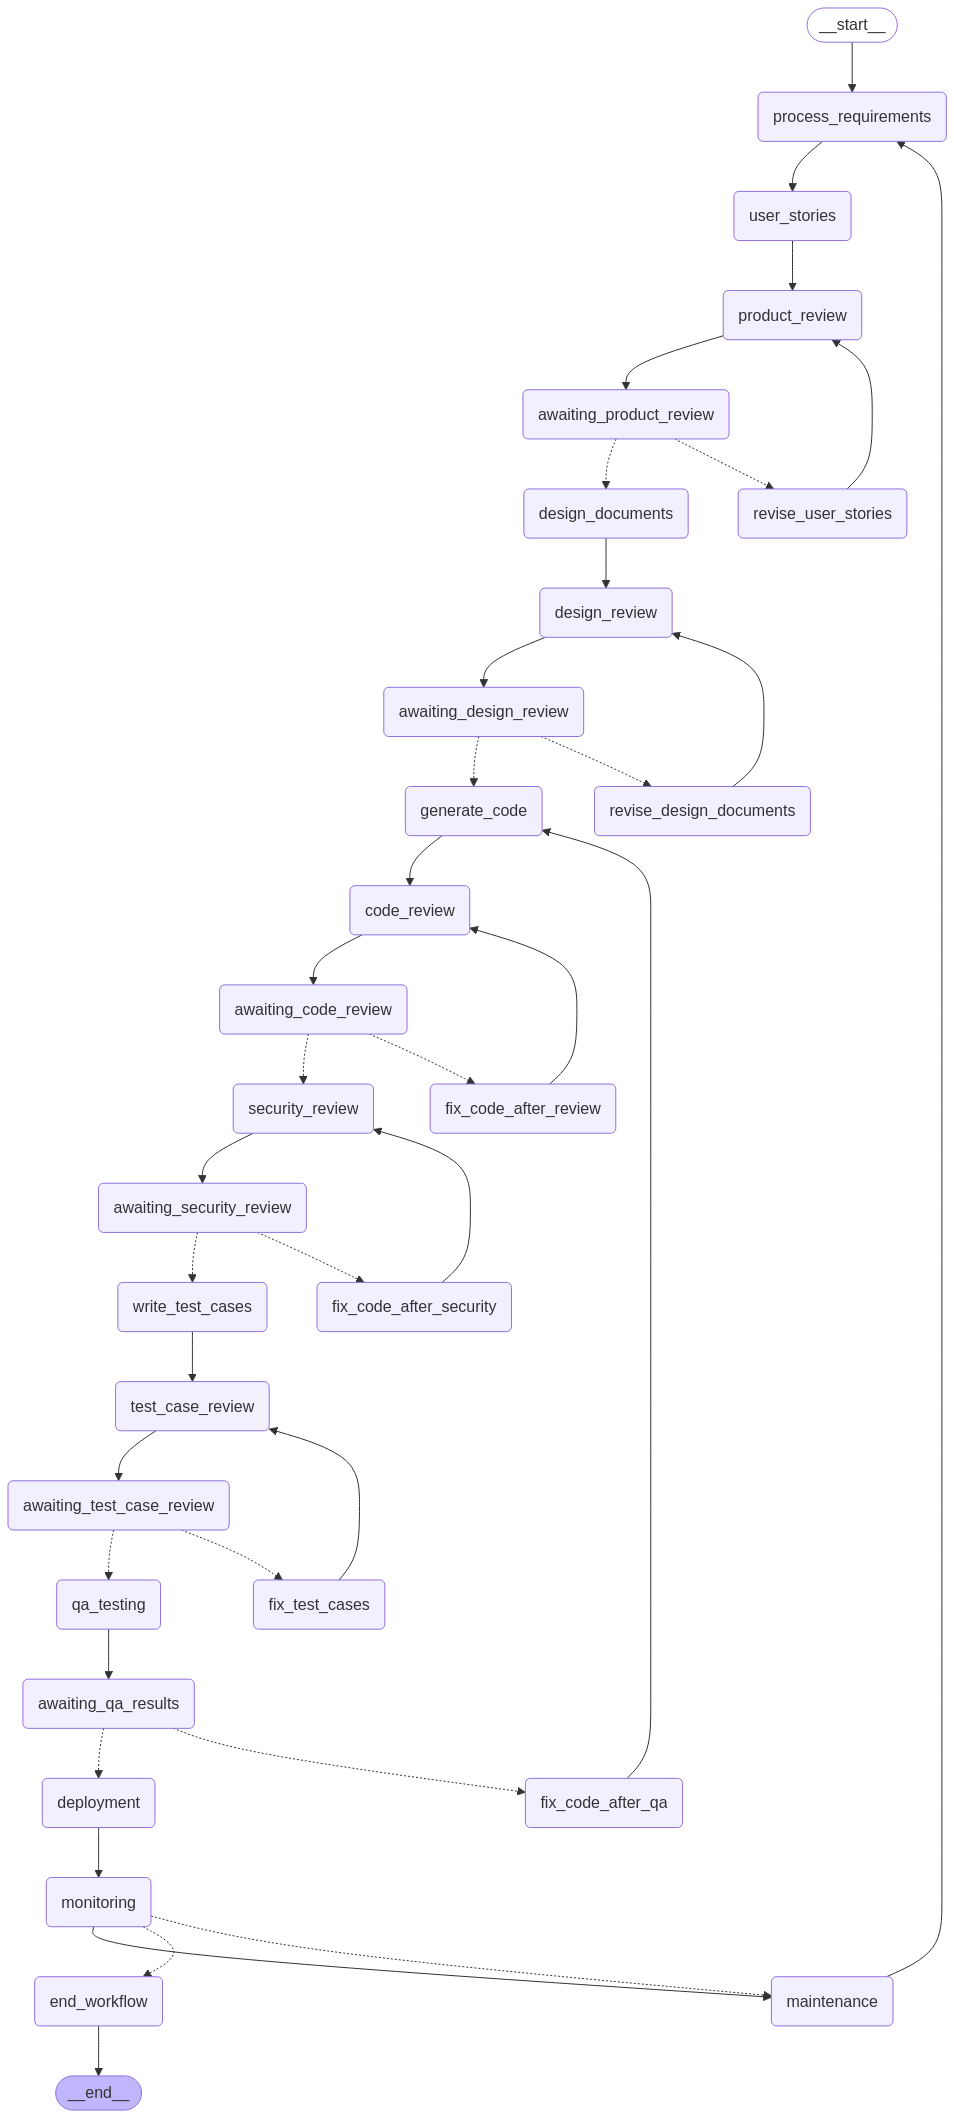

In [54]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from typing import Annotated, Dict, List, Sequence, TypedDict, Union, Literal
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, END, START
import operator
from langgraph.graph.message import add_messages
import logging
from datetime import datetime
import os
import json
import time
import random
import concurrent.futures

# Setup logging
log_filename = f"workflow_execution_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    filename=log_filename,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Mock ChatGroq for implementation
from langchain_groq import ChatGroq

from dotenv import load_dotenv
load_dotenv()
import os

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# Define your ChatGroq model
llm = ChatGroq(
    model="qwen-2.5-32b"
)

# Define state schema
class WorkflowState(TypedDict):
    messages: Annotated[Sequence[Union[HumanMessage, AIMessage, SystemMessage]], add_messages]
    user_input_requirements: str
    user_stories_content: str
    design_docs: str
    generated_code_components: Dict[str, str]
    test_cases_content: str
    review_status: Dict[str, Union[str, None]]
    current_stage: str
    feedback_data: Dict[str, str]
    deployment_status: str
    monitoring_info: str

# Initialize graph
workflow = StateGraph(WorkflowState)

# Define system prompts for each stage
system_prompts = {
    "user_requirements": "You are a requirements analyst. Extract and organize user requirements from the input.",
    "user_stories": "You are a product manager. Generate comprehensive user stories based on the provided requirements.",
    "product_review": "You are a product owner. Review the user stories for completeness and alignment with requirements.",
    "design_documents": "You are a solution architect. Create detailed functional and technical design documents based on the approved user stories.",
    "design_review": "You are a senior architect. Review the design documents for technical feasibility and architectural soundness.",
    "generate_code": "You are an expert software developer. Generate code based on the approved design documents.",
    "code_review": "You are a code reviewer. Review the code for quality, readability, and adherence to best practices.",
    "security_review": "You are a security expert. Review the code for potential security vulnerabilities and compliance issues.",
    "write_test_cases": "You are a QA engineer. Create comprehensive test cases for the implemented functionality.",
    "test_case_review": "You are a QA lead. Review the test cases for completeness and alignment with requirements.",
    "qa_testing": "You are a QA tester. Execute test cases and report any issues.",
    "deployment": "You are a DevOps engineer. Handle the deployment of the approved code.",
    "monitoring": "You are a system administrator. Monitor the deployed application, collect performance metrics, and ask the user if they want to continue or terminate the workflow.",
    "maintenance": "You are a maintenance engineer. Identify areas for improvement based on monitoring data."
}

# Stage 1: User Requirements
def process_user_requirements(state):
    try:
        messages = [
            SystemMessage(content=system_prompts["user_requirements"]),
            HumanMessage(content="Please analyze the following input and extract user requirements: " + state["messages"][-1].content)
        ]
        
        requirements = llm.invoke(messages).content
        
        return {
            "messages": [AIMessage(content=f"User requirements processed: {requirements}")],
            "user_input_requirements": requirements,
            "current_stage": "user_stories"
        }
    except Exception as e:
        logging.error(f"Error in process_user_requirements: {str(e)}")
        return {
            "messages": [AIMessage(content=f"Error processing requirements: {str(e)}")],
            "current_stage": "error_handling"
        }

def invoke_with_backoff(llm, messages, max_retries=5, initial_backoff=1):
    """
    Invokes the LLM with exponential backoff for rate limit handling
    
    Args:
        llm: The language model to use
        messages: The messages to send
        max_retries: Maximum number of retry attempts
        initial_backoff: Initial backoff time in seconds
        
    Returns:
        The LLM response
    """
    retries = 0
    backoff = initial_backoff
    
    while retries <= max_retries:
        try:
            return llm.invoke(messages)
        except Exception as e:
            if "429" in str(e) and retries < max_retries:
                # Add jitter to avoid thundering herd problem
                sleep_time = backoff + (random.random() * 0.5)
                logging.info(f"Rate limited. Backing off for {sleep_time:.2f} seconds. Retry {retries+1}/{max_retries}")
                time.sleep(sleep_time)
                retries += 1
                # Exponential backoff with jitter
                backoff = min(60, backoff * 2)
            else:
                raise
    
    raise Exception(f"Failed after {max_retries} retries")

def save_checkpoint(state, checkpoint_name=None):
    """Save the current state as a checkpoint"""
    if checkpoint_name is None:
        checkpoint_name = f"checkpoint_{state['current_stage']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    checkpoint_path = f"checkpoints/{checkpoint_name}.json"
    os.makedirs("checkpoints", exist_ok=True)
    
    with open(checkpoint_path, 'w') as f:
        json.dump(state_to_dict(state), f, indent=2)
    
    logging.info(f"Checkpoint saved: {checkpoint_path}")
    return checkpoint_path

# Stage 2: Generate User Stories
def generate_user_stories(state):
    messages = [
        SystemMessage(content=system_prompts["user_stories"]),
        HumanMessage(content=f"Generate user stories based on these requirements: {state['user_input_requirements']}")
    ]
    
    user_stories = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Generated user stories: {user_stories}")],
        "user_stories_content": user_stories,
        "current_stage": "product_review"
    }

def get_dynamic_system_prompt(stage, state):
    """Generate a dynamic system prompt based on the current state"""
    base_prompt = system_prompts[stage]
    
    if stage == "generate_code":
        # Add specific requirements from user stories
        base_prompt += f"\nEnsure you implement these key requirements:\n"
        # Extract key requirements from user stories
        # ...
    
    if stage == "security_review" and "security" in state["user_input_requirements"].lower():
        # Add specific security concerns
        base_prompt += f"\nPay special attention to authentication and authorization implementation."
    
    return base_prompt

# Stage 3: Product Owner Review
def product_owner_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review these user stories and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "product_review": None},
        "current_stage": "awaiting_product_review"
    }

# Human feedback handler for product review
def handle_product_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "product_review": "approved"}
        next_stage = "design_documents"
        message = "User stories approved. Moving to design document creation."
    else:
        review_status = {**state.get("review_status", {}), "product_review": "feedback"}
        next_stage = "revise_user_stories"
        message = "Feedback received. User stories need revision."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "product_review": feedback},
        "current_stage": next_stage
    }

# Revise user stories based on feedback
def revise_user_stories(state):
    messages = [
        SystemMessage(content=system_prompts["user_stories"]),
        HumanMessage(content=f"Revise the following user stories based on feedback: {state['user_stories_content']}"),
        HumanMessage(content=f"Feedback: {state['feedback_data'].get('product_review', '')}")
    ]
    
    revised_stories = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Revised user stories: {revised_stories}")],
        "user_stories_content": revised_stories,
        "current_stage": "product_review"
    }

# Stage 4: Create Design Documents
def create_design_documents(state):
    messages = [
        SystemMessage(content=system_prompts["design_documents"]),
        HumanMessage(content=f"Create functional and technical design documents based on these user stories: {state['user_stories_content']}")
    ]
    
    design_docs = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Created design documents: {design_docs}")],
        "design_docs": design_docs,
        "current_stage": "design_review"
    }

# Design Review
def design_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review these design documents and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "design_review": None},
        "current_stage": "awaiting_design_review"
    }

# Human feedback handler for design review
def handle_design_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "design_review": "approved"}
        next_stage = "generate_code"
        message = "Design documents approved. Moving to code generation."
    else:
        review_status = {**state.get("review_status", {}), "design_review": "feedback"}
        next_stage = "revise_design_documents"
        message = "Feedback received. Design documents need revision."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "design_review": feedback},
        "current_stage": next_stage
    }

# Revise design documents based on feedback
def revise_design_documents(state):
    messages = [
        SystemMessage(content=system_prompts["design_documents"]),
        HumanMessage(content=f"Revise the following design documents based on feedback: {state['design_docs']}"),
        HumanMessage(content=f"Feedback: {state['feedback_data'].get('design_review', '')}")
    ]
    
    revised_docs = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Revised design documents: {revised_docs}")],
        "design_docs": revised_docs,
        "current_stage": "design_review"
    }

# Stage 5: Generate Code
def generate_code(state):
    # Simulate multiple workers generating different parts of the code
    code_components = ["frontend", "backend", "database", "api"]
    generated_code = {}
    
    for component in code_components:
        messages = [
            SystemMessage(content=f"{system_prompts['generate_code']} Focus on the {component} component."),
            HumanMessage(content=f"Generate code for the {component} based on these design documents: {state['design_docs']}")
        ]
        
        component_code = llm.invoke(messages).content
        generated_code[component] = component_code
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in generated_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Generated code components: {code_summary}")],
        "generated_code_components": generated_code,
        "current_stage": "code_review"
    }

# Stage 6: Code Review
def code_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the generated code and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "code_review": None},
        "current_stage": "awaiting_code_review"
    }

# Human feedback handler for code review
def handle_code_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "code_review": "approved"}
        next_stage = "security_review"
        message = "Code approved. Moving to security review."
    else:
        review_status = {**state.get("review_status", {}), "code_review": "feedback"}
        next_stage = "fix_code_after_review"
        message = "Feedback received. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "code_review": feedback},
        "current_stage": next_stage
    }

# Fix code after review
def fix_code_after_review(state):
    fixed_code = {}
    
    for component, code in state["generated_code_components"].items():
        messages = [
            SystemMessage(content=system_prompts["generate_code"]),
            HumanMessage(content=f"Fix the following {component} code based on feedback: {code}"),
            HumanMessage(content=f"Feedback: {state['feedback_data'].get('code_review', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code components: {code_summary}")],
        "generated_code_components": fixed_code,
        "current_stage": "code_review"
    }

# Stage 7: Security Review
def security_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the code for security vulnerabilities and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "security_review": None},
        "current_stage": "awaiting_security_review"
    }

# Human feedback handler for security review
def handle_security_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "security_review": "approved"}
        next_stage = "write_test_cases"
        message = "Security review passed. Moving to test case writing."
    else:
        review_status = {**state.get("review_status", {}), "security_review": "feedback"}
        next_stage = "fix_code_after_security"
        message = "Security issues found. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "security_review": feedback},
        "current_stage": next_stage
    }

# Fix code after security review
def fix_code_after_security(state):
    fixed_code = {}
    
    for component, code in state["generated_code_components"].items():
        messages = [
            SystemMessage(content=f"{system_prompts['generate_code']} Focus on fixing security issues."),
            HumanMessage(content=f"Fix security issues in the following {component} code: {code}"),
            HumanMessage(content=f"Security feedback: {state['feedback_data'].get('security_review', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code with security improvements: {code_summary}")],
        "generated_code_components": fixed_code,
        "current_stage": "security_review"
    }

def generate_documentation(state):
    """Generate comprehensive documentation based on the current state"""
    docs = {
        "project_overview": {
            "requirements": state["user_input_requirements"],
            "user_stories": state["user_stories_content"],
            "design": state["design_docs"]
        },
        "implementation": {
            "code_components": {name: code[:500] + "..." for name, code in state["generated_code_components"].items()},
            "test_cases": state["test_cases_content"]
        },
        "deployment": {
            "status": state["deployment_status"],
            "monitoring": state["monitoring_info"]
        },
        "workflow_history": {
            "current_stage": state["current_stage"],
            "review_history": state["review_status"],
            "feedback_history": state["feedback_data"]
        }
    }
    
    # Save documentation
    with open("project_documentation.json", "w") as f:
        json.dump(docs, f, indent=2)
    
    return docs

def generate_code_parallel(state):
    """Generate code components in parallel"""
    code_components = ["frontend", "backend", "database", "api"]
    generated_code = {}
    
    def generate_component(component):
        """Helper function to generate a single component"""
        messages = [
            SystemMessage(content=f"{system_prompts['generate_code']} Focus on the {component} component."),
            HumanMessage(content=f"Generate code for the {component} based on these design documents: {state['design_docs']}")
        ]
        
        try:
            component_code = invoke_with_backoff(llm, messages).content
            return component, component_code
        except Exception as e:
            logging.error(f"Error generating {component} code: {str(e)}")
            return component, f"Error: {str(e)}"
    
    # Use ThreadPoolExecutor for parallel requests
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        future_to_component = {executor.submit(generate_component, comp): comp for comp in code_components}
        for future in concurrent.futures.as_completed(future_to_component):
            component, code = future.result()
            generated_code[component] = code
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in generated_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Generated code components: {code_summary}")],
        "generated_code_components": generated_code,
        "current_stage": "code_review"
    }

# Stage 8: Write Test Cases
def write_test_cases(state):
    messages = [
        SystemMessage(content=system_prompts["write_test_cases"]),
        HumanMessage(content=f"Write test cases for the following code components:")
    ]
    
    for component, code in state["generated_code_components"].items():
        messages.append(HumanMessage(content=f"{component} code: {code[:500]}..."))
    
    test_cases = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Generated test cases: {test_cases[:500]}...")],
        "test_cases_content": test_cases,
        "current_stage": "test_case_review"
    }

# Stage 9: Test Case Review
def test_case_review(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please review the test cases and provide feedback or approval.")
        ],
        "review_status": {**state.get("review_status", {}), "test_case_review": None},
        "current_stage": "awaiting_test_case_review"
    }

# Human feedback handler for test case review
def handle_test_case_review_feedback(state):
    feedback = state["messages"][-1].content
    
    if "approve" in feedback.lower():
        review_status = {**state.get("review_status", {}), "test_case_review": "approved"}
        next_stage = "qa_testing"
        message = "Test cases approved. Moving to QA testing."
    else:
        review_status = {**state.get("review_status", {}), "test_case_review": "feedback"}
        next_stage = "fix_test_cases"
        message = "Feedback received. Test cases need fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "test_case_review": feedback},
        "current_stage": next_stage
    }

# Fix test cases after review
def fix_test_cases(state):
    messages = [
        SystemMessage(content=system_prompts["write_test_cases"]),
        HumanMessage(content=f"Fix the following test cases based on feedback: {state['test_cases_content']}"),
        HumanMessage(content=f"Feedback: {state['feedback_data'].get('test_case_review', '')}")
    ]
    
    fixed_test_cases = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Fixed test cases: {fixed_test_cases[:500]}...")],
        "test_cases_content": fixed_test_cases,
        "current_stage": "test_case_review"
    }

# Stage 10: QA Testing
def qa_testing(state):
    # This would be a human-in-the-loop step, simulated here
    return {
        "messages": [
            HumanMessage(content="Please execute the test cases and report whether they passed or failed.")
        ],
        "review_status": {**state.get("review_status", {}), "qa_testing": None},
        "current_stage": "awaiting_qa_results"
    }

# Human feedback handler for QA testing results
def handle_qa_testing_results(state):
    feedback = state["messages"][-1].content
    
    if "pass" in feedback.lower():
        review_status = {**state.get("review_status", {}), "qa_testing": "passed"}
        next_stage = "deployment"
        message = "QA Testing passed. Moving to deployment."
    else:
        review_status = {**state.get("review_status", {}), "qa_testing": "failed"}
        next_stage = "fix_code_after_qa"
        message = "QA Testing failed. Code needs fixes."
    
    return {
        "messages": [AIMessage(content=message)],
        "review_status": review_status,
        "feedback_data": {**state.get("feedback_data", {}), "qa_testing": feedback},
        "current_stage": next_stage
    }

# Fix code after QA feedback
def fix_code_after_qa(state):
    fixed_code = {}
    
    for component, code in state["generated_code_components"].items():
        messages = [
            SystemMessage(content=system_prompts["generate_code"]),
            HumanMessage(content=f"Fix the following {component} code based on QA feedback: {code}"),
            HumanMessage(content=f"QA feedback: {state['feedback_data'].get('qa_testing', '')}")
        ]
        
        fixed_component = llm.invoke(messages).content
        fixed_code[component] = fixed_component
    
    code_summary = "\n".join([f"{comp}: {code[:100]}..." for comp, code in fixed_code.items()])
    
    return {
        "messages": [AIMessage(content=f"Fixed code after QA feedback: {code_summary}")],
        "generated_code_components": fixed_code,
        "current_stage": "generate_code"  # Going back to stage 5
    }

# Deployment
def deploy_code(state):
    messages = [
        SystemMessage(content=system_prompts["deployment"]),
        HumanMessage(content=f"Deploy the following code components:")
    ]
    
    for component, code in state["generated_code_components"].items():
        messages.append(HumanMessage(content=f"{component} code: {code[:200]}..."))
    
    deployment_result = llm.invoke(messages).content
    
    return {
        "messages": [AIMessage(content=f"Deployment result: {deployment_result}")],
        "deployment_status": "deployed",
        "current_stage": "monitoring"
    }

# Modify the monitor_system function to check for an end request
def monitor_system(state):
    # Generate monitoring data
    messages = [
        SystemMessage(content=system_prompts["monitoring"]),
        HumanMessage(content="Generate monitoring report for the deployed system.")
    ]
    monitoring_data = llm.invoke(messages).content
    
    # Prompt user for continuation
    return {
        "messages": [
            AIMessage(content=f"Monitoring Report:\n{monitoring_data}"),
            HumanMessage(content="Would you like to continue maintenance or end the workflow? (Type 'continue' or 'end')")
        ],
        "monitoring_info": monitoring_data,
        "current_stage": "awaiting_monitoring_decision"
    }

# New node to handle monitoring decision
def handle_monitoring_decision(state):
    user_input = state["messages"][-1].content.lower()
    
    if "end" in user_input:
        return {
            "messages": [AIMessage(content="Initiating workflow termination...")],
            "current_stage": "end_workflow"
        }
    else:
        return {
            "messages": [AIMessage(content="Continuing to maintenance phase.")],
            "current_stage": "maintenance"
        }
    
# Maintenance and Updates
def maintain_system(state):
    messages = [
        SystemMessage(content=system_prompts["maintenance"]),
        HumanMessage(content=f"Analyze monitoring data and suggest maintenance tasks: {state['monitoring_info']}")
    ]
    
    maintenance_suggestions = llm.invoke(messages).content
    
    return {
        "messages": [
            AIMessage(content=f"Maintenance suggestions: {maintenance_suggestions}"),
            AIMessage(content="Maintenance completed. Returning to monitoring.")
        ],
        "current_stage": "monitoring"  # Loop back to monitoring
    }

# End_workflow function
def end_workflow(state):
    return {
        "messages": [AIMessage(content="Workflow successfully terminated. Deployment remains active.")],
        "current_stage": "terminated"
    }

# Define the router function for conditional edges
def route_from_awaiting_product_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "design_documents":
        return "design_documents"
    elif current_stage == "revise_user_stories":
        return "revise_user_stories"
    return "revise_user_stories"  # Default fallback

def route_from_awaiting_design_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "generate_code":
        return "generate_code"
    elif current_stage == "revise_design_documents":
        return "revise_design_documents"
    return "revise_design_documents"  # Default fallback

def route_from_awaiting_code_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "security_review":
        return "security_review"
    elif current_stage == "fix_code_after_review":
        return "fix_code_after_review"
    return "fix_code_after_review"  # Default fallback

def route_from_awaiting_security_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "write_test_cases":
        return "write_test_cases"
    elif current_stage == "fix_code_after_security":
        return "fix_code_after_security"
    return "fix_code_after_security"  # Default fallback

def route_from_awaiting_test_case_review(state):
    current_stage = state.get("current_stage")
    if current_stage == "qa_testing":
        return "qa_testing"
    elif current_stage == "fix_test_cases":
        return "fix_test_cases"
    return "fix_test_cases"  # Default fallback

def route_from_awaiting_qa_results(state):
    current_stage = state.get("current_stage")
    if current_stage == "deployment":
        return "deployment"
    elif current_stage == "fix_code_after_qa":
        return "fix_code_after_qa"
    return "fix_code_after_qa"  # Default fallback

# Function to safely convert state to JSON-serializable format
def state_to_dict(state):
    result = {}
    for key, value in state.items():
        if key == 'messages':
            # Convert messages to serializable format
            result[key] = [{'type': type(msg).__name__, 'content': msg.content} for msg in value]
        elif isinstance(value, dict):
            result[key] = value
        else:
            result[key] = str(value)
    return result

# Add nodes to graph
workflow.add_node("process_requirements", process_user_requirements)
workflow.add_node("user_stories", generate_user_stories)
workflow.add_node("product_review", product_owner_review)
workflow.add_node("revise_user_stories", revise_user_stories)
workflow.add_node("design_documents", create_design_documents)
workflow.add_node("design_review", design_review)
workflow.add_node("revise_design_documents", revise_design_documents)
workflow.add_node("generate_code", generate_code)
workflow.add_node("code_review", code_review)
workflow.add_node("fix_code_after_review", fix_code_after_review)
workflow.add_node("security_review", security_review)
workflow.add_node("fix_code_after_security", fix_code_after_security)
workflow.add_node("write_test_cases", write_test_cases)
workflow.add_node("test_case_review", test_case_review)
workflow.add_node("fix_test_cases", fix_test_cases)
workflow.add_node("qa_testing", qa_testing)
workflow.add_node("fix_code_after_qa", fix_code_after_qa)
workflow.add_node("deployment", deploy_code)
workflow.add_node("monitoring", monitor_system)
workflow.add_node("awaiting_monitoring_decision", handle_monitoring_decision)
workflow.add_node("end_workflow", end_workflow)
workflow.add_node("maintenance", maintain_system)

# Human-in-the-loop feedback handlers
workflow.add_node("awaiting_product_review", handle_product_review_feedback)
workflow.add_node("awaiting_design_review", handle_design_review_feedback)
workflow.add_node("awaiting_code_review", handle_code_review_feedback)
workflow.add_node("awaiting_security_review", handle_security_review_feedback)
workflow.add_node("awaiting_test_case_review", handle_test_case_review_feedback)
workflow.add_node("awaiting_qa_results", handle_qa_testing_results)

# Add the START edge - this was missing before!
workflow.add_edge(START, "process_requirements")

# Add regular edges (direct connections between nodes)
workflow.add_edge("process_requirements", "user_stories")
workflow.add_edge("user_stories", "product_review")
workflow.add_edge("product_review", "awaiting_product_review")
workflow.add_edge("revise_user_stories", "product_review")
workflow.add_edge("design_documents", "design_review")
workflow.add_edge("design_review", "awaiting_design_review")
workflow.add_edge("revise_design_documents", "design_review")
workflow.add_edge("generate_code", "code_review")
workflow.add_edge("code_review", "awaiting_code_review")
workflow.add_edge("fix_code_after_review", "code_review")
workflow.add_edge("security_review", "awaiting_security_review")
workflow.add_edge("fix_code_after_security", "security_review")
workflow.add_edge("write_test_cases", "test_case_review")
workflow.add_edge("test_case_review", "awaiting_test_case_review")
workflow.add_edge("fix_test_cases", "test_case_review")
workflow.add_edge("qa_testing", "awaiting_qa_results")
workflow.add_edge("fix_code_after_qa", "generate_code")
workflow.add_edge("deployment", "monitoring")
workflow.add_edge("monitoring", "awaiting_monitoring_decision")
workflow.add_edge("end_workflow", END)
workflow.add_edge("maintenance", "monitoring")

# Add conditional edges using proper routing functions
workflow.add_conditional_edges(
    "awaiting_product_review",
    route_from_awaiting_product_review,
    {
        "design_documents": "design_documents",
        "revise_user_stories": "revise_user_stories"
    }
)

workflow.add_conditional_edges(
    "awaiting_design_review",
    route_from_awaiting_design_review,
    {
        "generate_code": "generate_code",
        "revise_design_documents": "revise_design_documents"
    }
)

workflow.add_conditional_edges(
    "awaiting_code_review",
    route_from_awaiting_code_review,
    {
        "security_review": "security_review",
        "fix_code_after_review": "fix_code_after_review"
    }
)

workflow.add_conditional_edges(
    "awaiting_security_review",
    route_from_awaiting_security_review,
    {
        "write_test_cases": "write_test_cases",
        "fix_code_after_security": "fix_code_after_security"
    }
)

workflow.add_conditional_edges(
    "awaiting_test_case_review",
    route_from_awaiting_test_case_review,
    {
        "qa_testing": "qa_testing",
        "fix_test_cases": "fix_test_cases"
    }
)

workflow.add_conditional_edges(
    "awaiting_qa_results",
    route_from_awaiting_qa_results,
    {
        "deployment": "deployment",
        "fix_code_after_qa": "fix_code_after_qa"
    }
)

# Add edge from monitoring to end_workflow
workflow.add_conditional_edges(
    "awaiting_monitoring_decision",
    lambda state: "end_workflow" if state["current_stage"] == "end_workflow" else "maintenance",
    {
        "end_workflow": "end_workflow",
        "maintenance": "maintenance"
    }
)

# Compile the graph
app = workflow.compile()

def run_workflow(user_input):
    logging.info(f"Starting workflow with input: {user_input[:100]}...")
    
    state = {
        "messages": [HumanMessage(content=user_input)],
        "user_input_requirements": "",
        "user_stories_content": "",
        "design_docs": "",
        "generated_code_components": {},
        "test_cases_content": "",
        "review_status": {},
        "current_stage": "process_requirements",
        "feedback_data": {},
        "deployment_status": "",
        "monitoring_info": ""
    }
    
    # Add configuration with increased recursion limit
    config = {"recursion_limit": 100}
    
    try:
        # Enable debug mode to get step-by-step execution
        result = app.invoke(state, config=config, debug=True)
        
        # Log successful execution
        logging.info("Workflow completed successfully")
        logging.info(f"Final state: {json.dumps(state_to_dict(result), indent=2)}")
        
        # Also write the result to a separate JSON file for easier analysis
        with open('workflow_result.json', 'w') as f:
            json.dump(state_to_dict(result), f, indent=2)
            
        return result
    
    except Exception as e:
        # Log the error
        logging.error(f"Workflow execution failed: {str(e)}")
        
        # If it's a recursion error, log additional information
        if "GraphRecursionError" in str(e):
            logging.error("Recursion limit reached. Check for infinite loops in your graph.")
            
        # Re-raise the exception
        raise

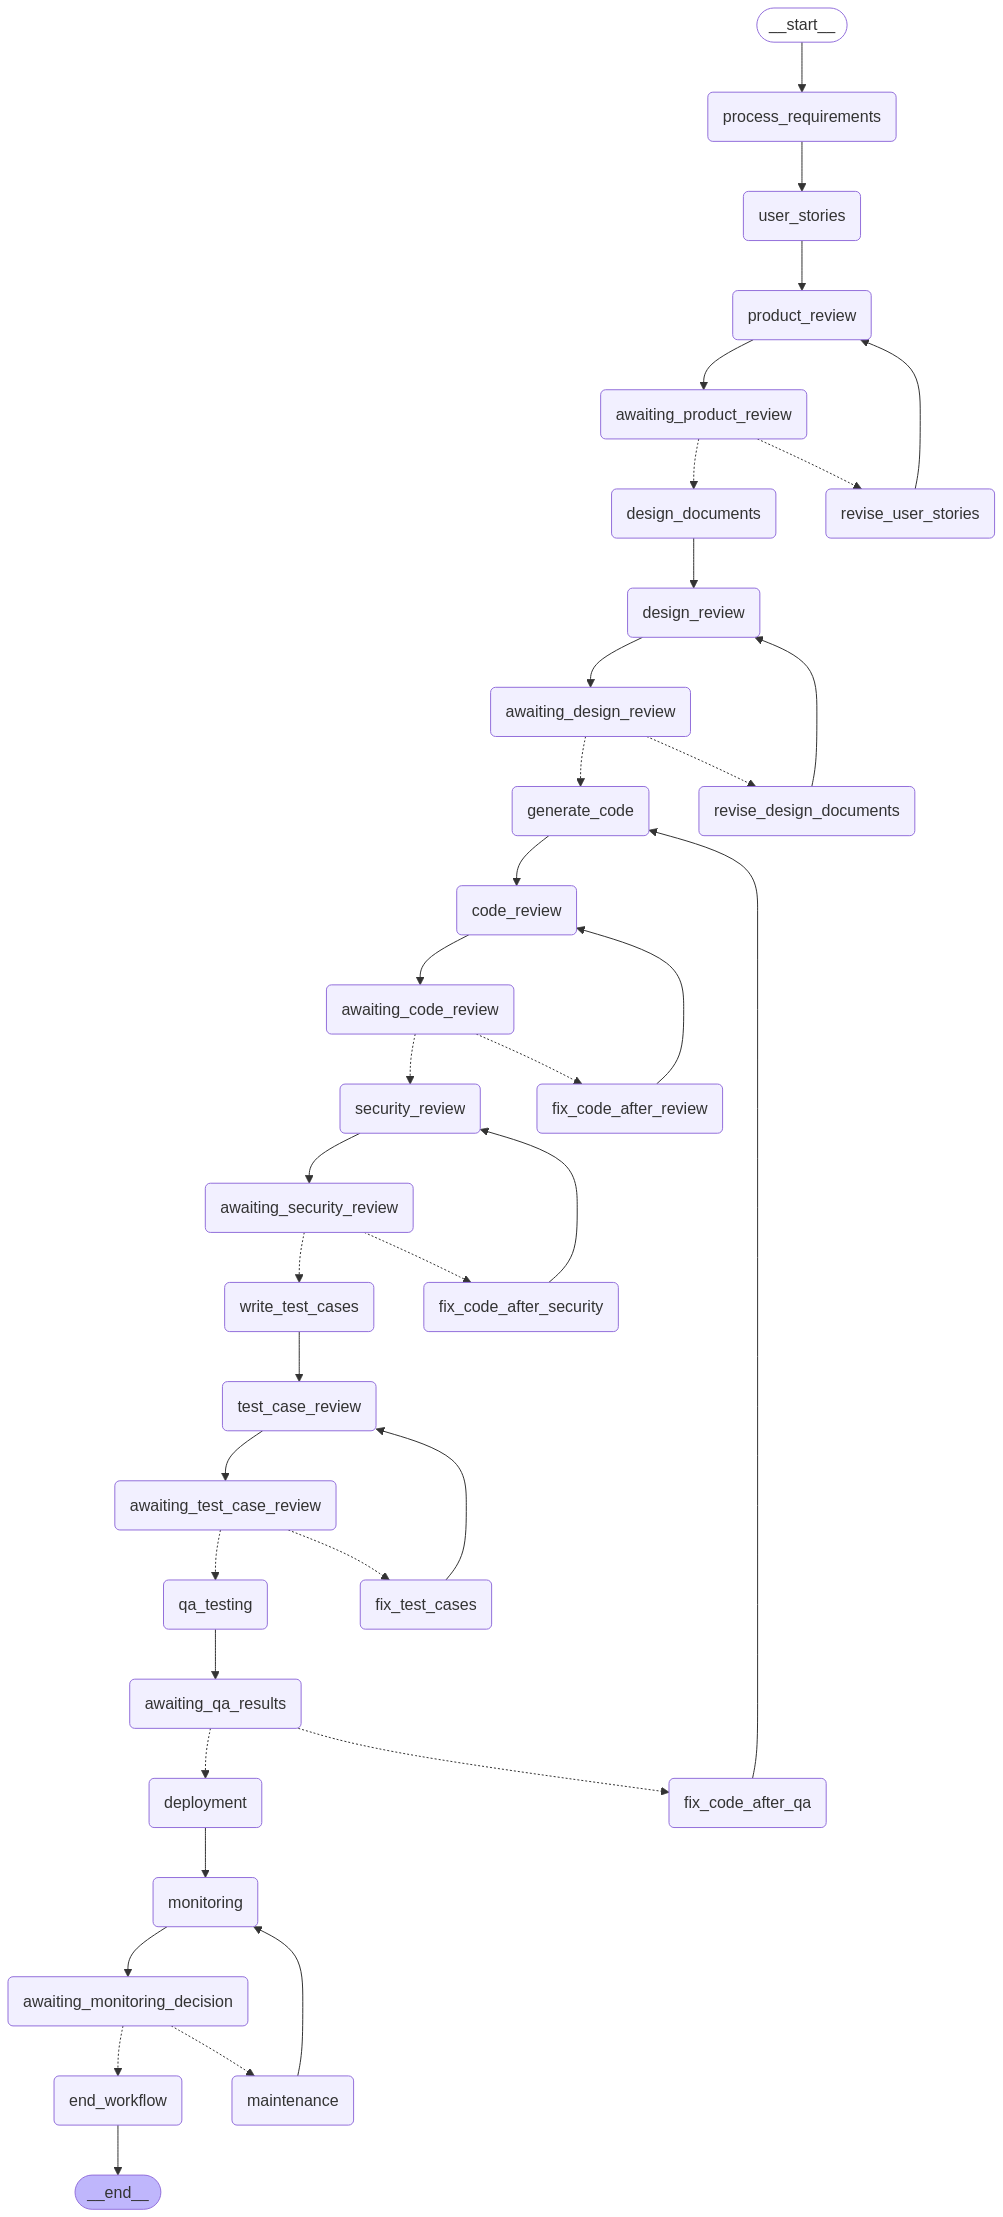

In [56]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [2]:
# Example usage
if __name__ == "__main__":
    # Sample input
    sample_input = """
    We need a web application for task management with the following features:
    1. User authentication
    2. Task creation, editing, and deletion
    3. Task categorization and filtering
    4. Due date reminders
    5. Task sharing between users
    """
    
    print(f"Log file will be created at: {os.path.abspath(log_filename)}")
    
    try:
        # Run the workflow
        result = run_workflow(sample_input)
        print("Workflow completed successfully!")
        print(f"Check log file at: {os.path.abspath(log_filename)}")
        print(f"Result JSON saved at: {os.path.abspath('workflow_result.json')}")
    except Exception as e:
        print(f"Workflow execution failed: {str(e)}")
        print(f"Check log file for details at: {os.path.abspath(log_filename)}")

Log file will be created at: d:\Rahul-Github\Daily-Task\Idea\workflow_execution_20250313_232058.log
[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'current_stage': 'process_requirements',
 'deployment_status': '',
 'design_docs': '',
 'feedback_data': {},
 'generated_code_components': {},
 'messages': [HumanMessage(content='\n    We need a web application for task management with the following features:\n    1. User authentication\n    2. Task creation, editing, and deletion\n    3. Task categorization and filtering\n    4. Due date reminders\n    5. Task sharing between users\n    ', additional_kwargs={}, response_metadata={})],
 'monitoring_info': '',
 'review_status': {},
 'test_cases_content': '',
 'user_input_requirements': '',
 'user_stories_content': ''}
[0:writes] Finished step 0 with writes to 11 channels:
- messages -> [HumanMessage(content='\n    We need a web application for task management with the follow

: 